In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2

from Faraday.two_dim.module.lib.layers import *
import Faraday.two_dim.module.lib.functions as func
from Faraday.two_dim.module.lib import optical_chart

plt.rcParams["font.size"]=18
plt.rcParams["image.cmap"] = "viridis"
plt.rcParams["axes.grid"] = False

$$
\begin{aligned}
\dfrac{\partial \mathcal{L}}{\partial \phi^{n-1}(x,y)} &=
\dfrac{\partial \mathcal{L}}{\partial I^n_{out}(x,y)}
\dfrac{\partial I^n_{out}(x,y)}{\partial E^n_{in}(x,y)}
\dfrac{\partial E^n_{in}(x,y)}{\partial E^{n-1}_{out}(x,y)}
\dfrac{\partial E^{n-1}_{out}(x,y)}{\partial \phi^{n-1}(x,y)} \\

\dfrac{\partial \mathcal{L}}{\partial I^n_{out}(x,y)} &= 2(I^n_{out}(x,y)-I^{target}(x,y)) \\

\dfrac{\partial I^n_{out}(x,y)}{\partial E^n_{in}(x,y)} &= \dfrac{\partial E^n_{in}(x,y)\bar{E}^n_{in}(x,y)}{\partial E^n_{in}(x,y)}=2\bar{E}^n_{in}(x,y) \\

\dfrac{\partial E^n_{in}(x,y)}{\partial E^{n-1}_{out}(x,y)} &=
\dfrac{\partial}{\partial E^{n-1}_{out}(x,y)} \iint
\left \{
  \left(
    \iint E^{n-1}_{out}(x,y)\exp(-i2\pi(ux+vy))dxdy
  \right)
  H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))
  \right \}
dudv \\

&= \iint \left \{ \left( \iint \exp(-i2\pi(ux+vy))dxdy \right)H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))\right \}dudv \\

&= \iint \delta(u)\delta(v) H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))dudv \\

&=  \mathcal{F}[\delta(u)\delta(v)H(x,y,z^n-z^{n-1})] \\

\dfrac{\partial E^{n-1}_{out}}{\partial \phi^{n-1}} &= Re\left \{iE^{n-1}_{in} \exp \left ( i\phi^{n-1} \right )\right \}
\end{aligned}
$$

共通変数

In [2]:
shape = (100, 100)

wavelength = 633e-9
d = 1.0e-6
z = 0.4e-3
u = np.fft.fftfreq(shape[1], d)
v = np.fft.fftfreq(shape[0], d)
UU, VV = np.meshgrid(u, v)
du = 1.0 / (shape[1] * d)
dv = 1.0 / (shape[0] * d)
u_lim = 1.0 / (wavelength * np.sqrt((2.0 * du * z) ** 2 + 1.0))
v_lim = 1.0 / (wavelength * np.sqrt((2.0 * dv * z) ** 2 + 1.0))
u_filter = np.where(np.abs(UU / (2 * u_lim)) < 1 / 2, 1, 0)
v_filter = np.where(np.abs(VV / (2 * v_lim)) < 1 / 2, 1, 0)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H = tf.constant(np.exp(1.0j * 2.0 * np.pi * w * z) * u_filter * v_filter, dtype=tf.complex128)

u_lim = 1.0 / (wavelength * np.sqrt((2.0 * du * 2*z) ** 2 + 1.0))
v_lim = 1.0 / (wavelength * np.sqrt((2.0 * dv * 2*z) ** 2 + 1.0))
u_filter = np.where(np.abs(UU / (2 * u_lim)) < 1 / 2, 1, 0)
v_filter = np.where(np.abs(VV / (2 * v_lim)) < 1 / 2, 1, 0)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H2 = tf.constant(np.exp(1.0j * 2.0 * np.pi * w * 2*z) * u_filter * v_filter, dtype=tf.complex128)

y = np.zeros(shape)
y[40:60,40:60] = 1.0
y = tf.constant(y)
data = tf.constant(np.loadtxt("../Faraday/two_dim/data/phase/100px/train_5.csv"), dtype=tf.complex128)

# phi = tf.Variable(np.random.random(shape) * np.pi)
phi = tf.Variable(np.random.random(shape)*2.0)
phi2 = tf.Variable(np.random.random(shape)*2.0)
phi3 = tf.Variable(np.random.random(shape)*2.0)

iter = 500
alpha = 0.9
beta1 = 0.1
beta2 = 0.1
history = []
v1 = 0.0
s1 = 0.0

Metal device set to: Apple M1


2022-10-20 11:49:39.668535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 11:49:39.668775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# GradientTapeでの実装

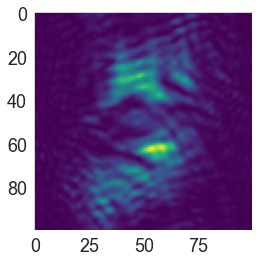

In [334]:
for i in range(iter):
    with tf.GradientTape() as tape:
        tape.watch(phi)
        x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
        x2 = tf.signal.fft2d(x1)
        x3 = tf.signal.ifft2d(x2 * H)
        x4 = x3 * tf.math.conj(x3)
        loss = tf.reduce_mean((y-tf.math.real(x4))**2)

    history.append(loss.numpy())
    dL_dphi = tape.gradient(loss, phi)
    v1 = beta1*v1 + (1-beta1) * dL_dphi
    s1 = beta2*s1 + (1-beta1) * dL_dphi**2
    phi = phi - alpha * v1 / tf.sqrt(s1 + 1.0e-7)

plt.imshow(x4.numpy().real)

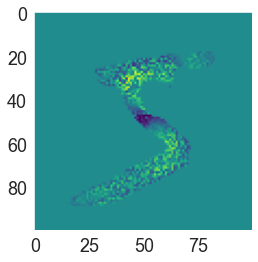

In [336]:
plt.imshow(dL_dphi)

# 自力計算とtape.gradientの比較
## 1層目

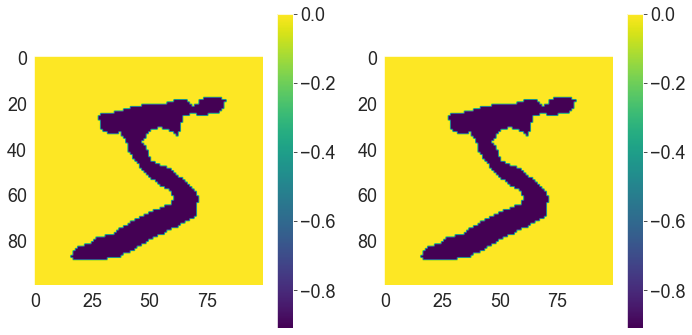

In [55]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = data * tf.complex(tf.cos(phi), tf.sin(phi))

tape_grad = tape.gradient(x1, phi)

# myself
x1 = data * tf.constant(np.exp(1.0j * phi.numpy()), dtype=tf.complex128)
my_grad = 1.0j * x1

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

## 2層目

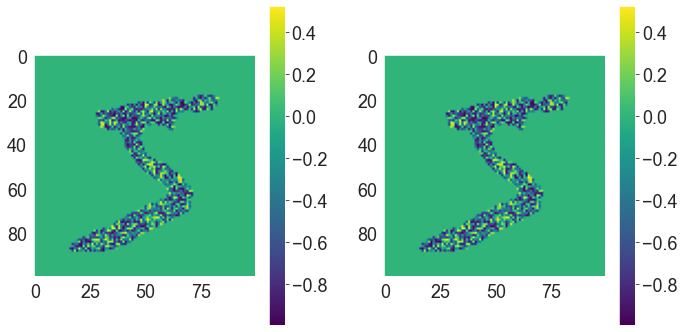

In [29]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)

tape_grad = tape.gradient(x3, phi)

# myself
x1 = data * tf.constant(np.exp(1.0j * phi.numpy()), dtype=tf.complex128)
my_grad = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(tf.constant(tf.ones_like(x1), dtype=tf.complex128)) * H)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy().real)
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

## 3層目

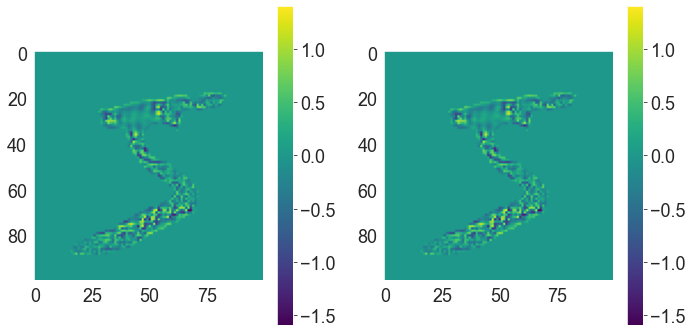

In [354]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)
    x4 = tf.reduce_sum(x3*tf.math.conj(x3))

tape_grad = tape.gradient(x4, phi)

# myself
my_grad2 = tf.math.conj(x3)
my_grad3 = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(tf.math.conj(x3)) * H)
my_grad4 = -1.0j * tf.math.conj(x1) * tf.signal.ifft2d(tf.signal.fft2d(x3) * tf.math.conj(H))
tmp = x1 * tf.signal.ifft2d(tf.signal.fft2d(tf.math.conj(x3)) * H)
my_grad = 1.0j * tmp -1.0j*tf.math.conj(tmp)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

## 誤差

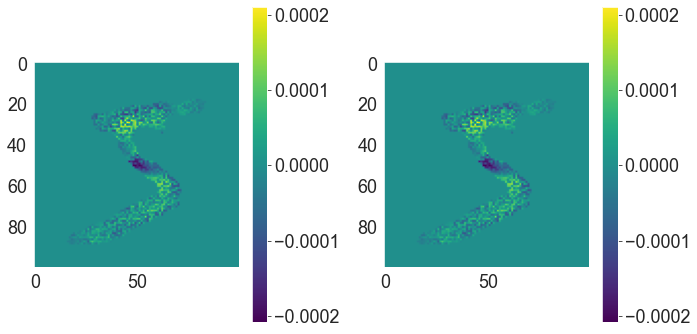

In [18]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)
    x4 = x3 * tf.math.conj(x3)
    loss = tf.reduce_mean((tf.math.real(x4)-y)**2)


tape_grad = tape.gradient(loss, phi)

# myself
my_grad1 = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(4*(x4-tf.complex(y, 0.0*y))*tf.math.conj(x3)) * H)
my_grad = my_grad1
my_grad = my_grad/(100*100)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

In [321]:
tf.math.conj(x3[0][0])

<tf.Tensor: shape=(), dtype=complex128, numpy=(0.0954986932146474-0.015414390535898832j)>

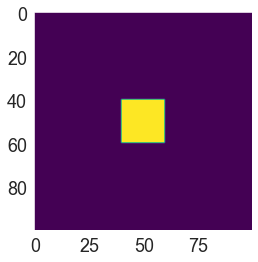

In [4]:
plt.imshow(y)

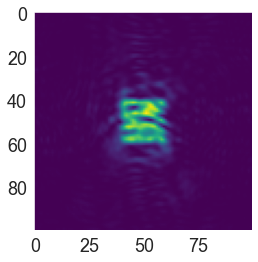

In [5]:
for i in range(500):
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)
    x4 = x3 * tf.math.conj(x3)
    loss = tf.reduce_mean((tf.math.real(x4)-y)**2)
    history.append(loss.numpy())

    my_grad1 = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(2*(x4-tf.complex(y, 0.0*y))*tf.math.conj(x3)) * H)
    my_grad2 = -1.0j * tf.math.conj(x1) * tf.signal.ifft2d(tf.signal.fft2d(2*(x4-tf.complex(y, 0.0*y))*x3) * tf.math.conj(H))
    my_grad = my_grad1 + my_grad2
    my_grad = my_grad/(100.0*100.0)

    v1 = beta1*v1 + (1-beta1) * my_grad.numpy().real
    s1 = beta2*s1 + (1-beta1) * my_grad.numpy().real**2
    phi = phi - alpha * v1 / tf.sqrt(s1 + 1.0e-7)

plt.imshow(x4.numpy().real)

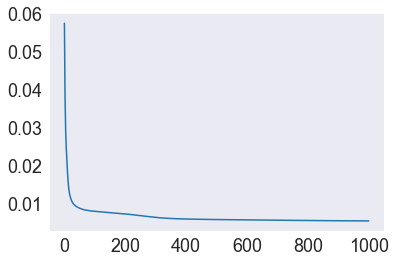

In [353]:
plt.plot(history)

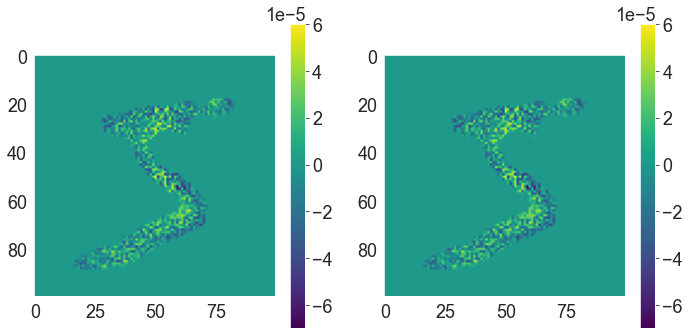

In [93]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)
    x4 = tf.complex(tf.cos(phi2), tf.sin(phi2)) * x3
    x5 = tf.signal.fft2d(x4)
    x6 = tf.signal.ifft2d(x5 * H)
    x7= x6 * tf.math.conj(x6)
    loss = tf.reduce_mean((tf.math.real(x7)-y)**2)


tape_grad = tape.gradient(loss, phi)

# myself
my_grad = tf.signal.ifft2d(
    tf.signal.fft2d(
        4*(x7-tf.complex(y, 0.0*y)) * tf.math.conj(x6)) * H
)

my_grad = tf.constant(tf.complex(tf.cos(phi2), tf.sin(phi2)), dtype=tf.complex128) * my_grad

my_grad =tf.signal.ifft2d(tf.signal.fft2d(my_grad)* H)

my_grad1 = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(4*(x7-tf.complex(y, 0.0*y))*tf.math.conj(x6)) * H)
my_grad = 1.0j * x1 * my_grad / (100*100)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

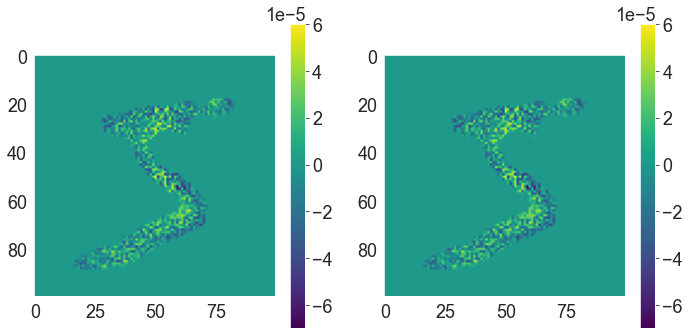

In [96]:
# tape
with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = tf.signal.fft2d(x1)
    x3 = tf.signal.ifft2d(x2 * H)
    x4 = tf.complex(tf.cos(phi2), tf.sin(phi2)) * x3
    x5 = tf.signal.fft2d(x4)
    x6 = tf.signal.ifft2d(x5 * H)
    x7= x6 * tf.math.conj(x6)
    loss = tf.reduce_mean((tf.math.real(x7)-y)**2)


tape_grad = tape.gradient(loss, phi)

# myself
my_grad = tf.signal.ifft2d(
    tf.signal.fft2d(
        4*(x7-tf.complex(y, 0.0*y)) * tf.math.conj(x6)) * H
)

my_grad = tf.constant(tf.complex(tf.cos(phi2), tf.sin(phi2)), dtype=tf.complex128) * my_grad

my_grad =tf.signal.ifft2d(tf.signal.fft2d(my_grad)* H)

my_grad1 = 1.0j * x1 * tf.signal.ifft2d(tf.signal.fft2d(4*(x7-tf.complex(y, 0.0*y))*tf.math.conj(x6)) * H)
my_grad = 1.0j * x1 * my_grad / (100*100)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

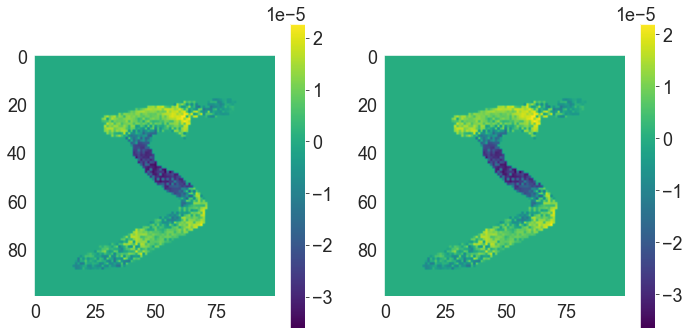

In [124]:
# tape
def propagation(src):
    pad_image = tf.pad(src, [[50, 50],[50,50]])
    u = np.fft.fftfreq(pad_image.shape[1], d=d)
    v = np.fft.fftfreq(pad_image.shape[0], d=d)

    du = 1 / (pad_image.shape[1] * d)
    dv = 1 / (pad_image.shape[0] * d)
    u_limit = 1 / (np.sqrt((2 * du * z) ** 2 + 1)) / wavelength
    v_limit = 1 / (np.sqrt((2 * dv * z) ** 2 + 1)) / wavelength
    UU, VV = np.meshgrid(u, v)

    u_filter = np.where(np.abs(UU) <= u_limit, 1, 0)
    v_filter = np.where(np.abs(VV) <= v_limit, 1, 0)

    w = np.where(UU ** 2 + VV ** 2 <= 1 / wavelength ** 2, tf.sqrt(1 / wavelength ** 2 - UU ** 2 - VV ** 2), 0).astype('float64')
    h = np.exp(1.0j * 2 * np.pi * w * z)
    h = h * u_filter * v_filter
    image = tf.signal.ifft2d(tf.signal.fft2d(pad_image)* tf.constant(h))
    return image[50:150, 50:150]

with tf.GradientTape() as tape:
    tape.watch(phi)
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = propagation(x1)
    x3 = tf.complex(tf.cos(phi2), tf.sin(phi2)) * x2
    x4 = propagation(x3)
    x5 = tf.complex(tf.cos(phi3), tf.sin(phi3)) * x4
    x6 = propagation(x5)
    x7= x6 * tf.math.conj(x6)
    loss = tf.reduce_mean((tf.math.real(x7)-y)**2)


tape_grad = tape.gradient(loss, phi)

# myself
my_grad = tf.signal.ifft2d(
    tf.signal.fft2d(
        4*(x7-tf.complex(y, 0.0*y)) * tf.math.conj(x6)) * H
)

my_grad = tf.constant(tf.complex(tf.cos(phi3), tf.sin(phi3)), dtype=tf.complex128) * my_grad

my_grad = propagation(my_grad)

my_grad = tf.constant(tf.complex(tf.cos(phi2), tf.sin(phi2)), dtype=tf.complex128) * my_grad

my_grad = propagation(my_grad)

my_grad = 1.0j * x1 * my_grad / (100*100)

fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy())
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

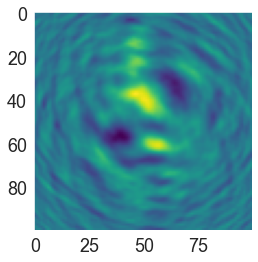

In [127]:
for i in range(100):
    x1 = tf.constant(data, dtype=tf.complex128) * tf.complex(tf.cos(phi), tf.sin(phi))
    x2 = propagation(x1)
    x3 = tf.complex(tf.cos(phi2), tf.sin(phi2)) * x2
    x4 = propagation(x3)
    x5 = tf.complex(tf.cos(phi3), tf.sin(phi3)) * x4
    x6 = propagation(x5)
    x7= x6 * tf.math.conj(x6)
    loss = tf.reduce_mean((tf.math.real(x7)-y)**2)
    history.append(loss.numpy())

    my_grad = tf.signal.ifft2d(
        tf.signal.fft2d(
            4*(x7-tf.complex(y, 0.0*y)) * tf.math.conj(x6)) * H
    )

    my_grad1 = tf.constant(tf.complex(tf.cos(phi3), tf.sin(phi3)), dtype=tf.complex128) * my_grad

    my_grad2 = propagation(my_grad1)

    my_grad3 = tf.constant(tf.complex(tf.cos(phi2), tf.sin(phi2)), dtype=tf.complex128) * my_grad2

    my_grad4 = propagation(my_grad3)

    my_grad5 = 1.0j * x1 * my_grad4 / (100*100)

    v1 = beta1*v1 + (1-beta1) * my_grad5.numpy().real
    s1 = beta2*s1 + (1-beta1) * my_grad5.numpy().real**2
    phi = phi - alpha * v1 / tf.sqrt(s1 + 1.0e-7)

plt.imshow(x4.numpy().real)

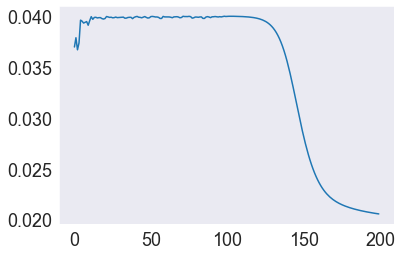

In [128]:
plt.plot(history)